<a href="https://colab.research.google.com/github/YuriiKlim/AI/blob/Neural_lesson3/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [77]:
import torch
import pandas as pd

torch.manual_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

Дані про діабет

In [78]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/Healthcare-Diabetes.csv',
                 index_col='Id')

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

In [79]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Id,,,,,,,,,
1,0.352941,0.743719,0.590164,0.318182,0.000000,0.416873,0.234415,0.483333,1
2,0.058824,0.427136,0.540984,0.263636,0.000000,0.330025,0.116567,0.166667,0
3,0.470588,0.919598,0.524590,0.000000,0.000000,0.289082,0.253629,0.183333,1
4,0.058824,0.447236,0.540984,0.209091,0.111111,0.348635,0.038002,0.000000,0
5,0.000000,0.688442,0.327869,0.318182,0.198582,0.534739,0.943638,0.200000,1
...,...,...,...,...,...,...,...,...,...
2764,0.117647,0.376884,0.524590,0.218182,0.065012,0.368486,0.124680,0.200000,0
2765,0.470588,0.899497,0.590164,0.381818,0.153664,0.405707,0.273698,0.250000,1
2766,0.352941,0.427136,0.639344,0.000000,0.000000,0.387097,0.129804,0.350000,0


Потрібно на основі інформації пацієнта виявити наявність діабету `Outcome`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [80]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values)
      self.y = torch.FloatTensor(y.values)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['Outcome'])
y = df['Outcome']

dataset = MyDataset(X, y)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=y)

dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)

# Завдання 2
Створіть DataLoader

In [82]:
from torch.utils.data import DataLoader

batch_size = 64
train_dl = DataLoader(dataset_train,
                      batch_size=batch_size,
                      generator=torch.Generator(device=device))
test_dl = DataLoader(dataset_test,
                     batch_size=batch_size,
                     shuffle=True,
                     generator=torch.Generator(device=device))

# Завдання 3
Створіть нейромережу

In [83]:
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import numpy as np

class Model(nn.Module):
    def __init__(self, input_size=2, hidden_sizes=[4], output_size=1):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Sigmoid())
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))

        self.layers.append(nn.Sigmoid())
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def predict(self, x, device='cpu'):
        x = torch.FloatTensor(np.array(x)).to(device)
        self.to(device)
        self.eval()
        with torch.no_grad():
            y_pred = self.forward(x)
        return y_pred.cpu().numpy()

model = Model(input_size=8, hidden_sizes=[16, 10, 8, 4], output_size=1)

In [84]:
from torchsummary import summary

summary(model, input_size=(8,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             144
           Sigmoid-2                   [-1, 16]               0
            Linear-3                   [-1, 10]             170
           Sigmoid-4                   [-1, 10]               0
            Linear-5                    [-1, 8]              88
           Sigmoid-6                    [-1, 8]               0
            Linear-7                    [-1, 4]              36
           Sigmoid-8                    [-1, 4]               0
            Linear-9                    [-1, 1]               5
Total params: 443
Trainable params: 443
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
---------------------------------------------------

# Завдання 4
Визначте функцію втрат та оптимізатор

In [85]:
loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.99)

# Завдання 5
Натренуйте нейромережу. Візміть невелику кількість епох

In [86]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [87]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_dl, test_dl,
                epochs=50,
                metrics=[accuracy_score, roc_auc_score],
                device=device,
                task='binary')

train() called: model=Model, opt=SGD(lr=0.001000), epochs=50, device=cuda

Epoch    1    0sec	loss:      0.648	val_loss:      0.667	accuracy_score:      0.656	val_accuracy_score:      0.655	roc_auc_score:      0.494	val_roc_auc_score:      0.483	
Epoch    2    0sec	loss:      0.661	val_loss:      0.655	accuracy_score:      0.656	val_accuracy_score:      0.655	roc_auc_score:        0.5	val_roc_auc_score:      0.458	
Epoch    3    0sec	loss:      0.644	val_loss:      0.654	accuracy_score:      0.656	val_accuracy_score:      0.655	roc_auc_score:      0.496	val_roc_auc_score:      0.484	
Epoch    4    0sec	loss:      0.653	val_loss:      0.648	accuracy_score:      0.656	val_accuracy_score:      0.655	roc_auc_score:      0.503	val_roc_auc_score:      0.465	
Epoch    5    0sec	loss:      0.644	val_loss:      0.648	accuracy_score:      0.656	val_accuracy_score:      0.655	roc_auc_score:      0.498	val_roc_auc_score:      0.486	
Epoch    6    0sec	loss:      0.649	val_loss:      0.645	accuracy

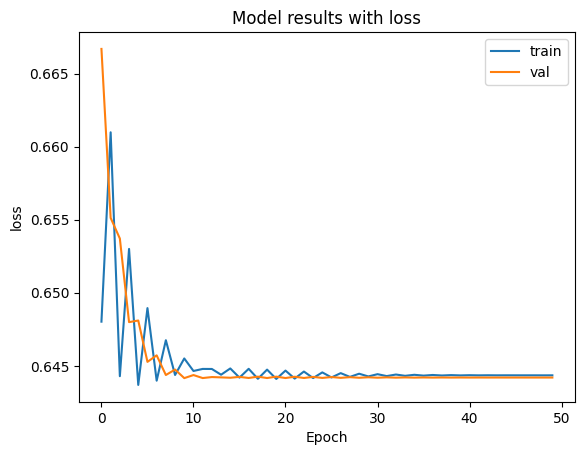

In [88]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()


plot_metric(history, 'loss')

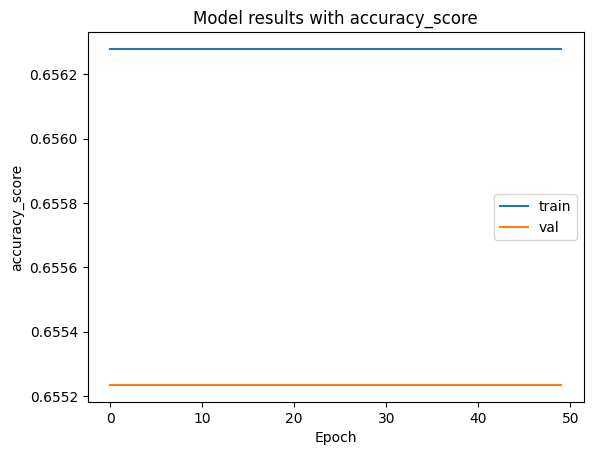

In [89]:
plot_metric(history, 'accuracy_score')

In [90]:
print(X_test)

      Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
Id                                                                              
714      0.000000  0.673367       0.475410       0.181818  0.343972  0.327543   
437      0.705882  0.703518       0.696721       0.300000  0.000000  0.464020   
771      0.000000  0.728643       0.000000       0.000000  0.000000  0.548387   
1012     0.352941  0.597990       0.409836       0.200000  0.208038  0.336228   
2326     0.411765  0.979899       0.573770       0.300000  0.171395  0.311414   
...           ...       ...            ...            ...       ...       ...   
1752     0.117647  0.457286       0.508197       0.000000  0.000000  0.338710   
2704     0.411765  0.804020       0.442623       0.290909  0.206856  0.378412   
856      0.117647  0.502513       0.557377       0.227273  0.083924  0.477667   
1285     0.529412  0.728643       0.721311       0.309091  0.195035  0.375931   
2192     0.294118  0.482412 

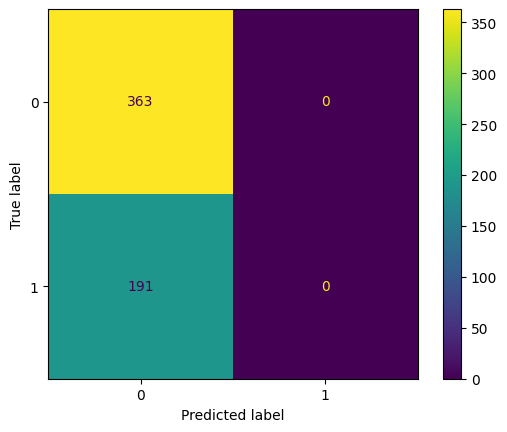

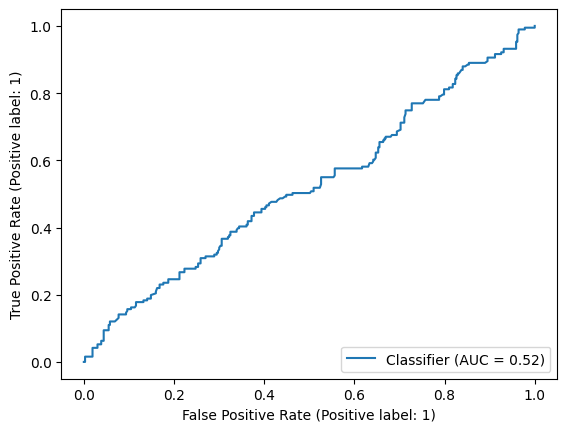

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

X_test_numpy = X_test.values.astype(np.float32)

y_pred = model.predict(X_test_numpy)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round())
plt.show()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)
plt.show()

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [92]:
torch.save(model.state_dict(), 'model.pth')

In [93]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>